# Sky region

### Field star region selection.

We will begin without the Bailer-Jones priors. That will be later.

https://www.aanda.org/articles/aa/abs/2019/04/aa34337-18/aa34337-18.html

From here we will take a region on the sky with b=-35,l=160, we expect reddening increase around 400pc as per the paper above.

See Fig 5 (a).

reddening vector in 2mass:
The resultant ratios are AKS /EH −KS = 1.46 ± 0.03 and AKS /EJ −KS = 0.499 ± 0.018, quite consistent with the previously derived ratios 1.44 ± 0.01, 0.494 ± 0.006 in Nishiyama et al. (2006). Therefore, the use of RGB colors does not affect the results.
https://iopscience.iop.org/article/10.1088/0004-637X/696/2/1407/pdf

https://gea.esac.esa.int/archive/documentation/GDR2/Data_analysis/chap_cu8par/sec_cu8par_process/ssec_cu8par_process_priamextinction.html

Above talks about the different redenning vectors for Gaia and how it does depend on the different temperatuere of stars but for relatively hot stars the Ag=2E works ok.

Look also at https://arxiv.org/pdf/1008.0815.pdf

Need to consider different stars.

Data input

In [1]:
%matplotlib inline

4 degree circle now!

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import os
import torch
if('High_latitude_sample' in os.getcwd()):
    os.chdir('../')
from star_sample import StarSample, Isochrones





job4 = Gaia.launch_job_async("SELECT * \
FROM gaiadr3.gaia_source AS g, gaiadr3.astrophysical_parameters AS p, gaiaedr3_distance as d \
WHERE g.source_id = p.source_id \
AND g.source_id=d.source_id \
AND CONTAINS(POINT(g.l,g.b),CIRCLE(160.0,-35.0,4))=1;", dump_to_file=False)


r = job4.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:

job4 = Gaia.launch_job_async("SELECT * \
FROM gaiadr3.gaia_source AS g \
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id) \
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid) \
JOIN gaiadr1.tmass_original_valid AS tmass ON xjoin.original_psc_source_id = tmass.designation \
WHERE CONTAINS(POINT(g.l,g.b),CIRCLE(160.0,-35.0,4))=1;", dump_to_file=False)


r2MASS = job4.get_results()



INFO: Query finished. [astroquery.utils.tap.core]


We need some prior on the distance but for now we wil just use the parallax.

# Parallax error

As per Bailer Jones, prior needed for about 20 percent error on parallax, which amounts to 40% of the stars along the line of sight.

In [4]:
r

solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,solution_id_2,source_id_2,classprob_dsc_combmod_quasar_2,classprob_dsc_combmod_galaxy_2,classprob_dsc_combmod_star_2,classprob_dsc_combmod_whitedwarf,classprob_dsc_combmod_binarystar,classprob_dsc_specmod_quasar,classprob_dsc_specmod_galaxy,classprob_dsc_specmod_star,classprob_dsc_specmod_whitedwarf,classprob_dsc_specmod_binarystar,classprob_dsc_allosmod_quasar,classprob_dsc_allosmod_galaxy,classprob_dsc_allosmod_star,teff_gspphot_2,teff_gspphot_lower_2,teff_gspphot_upper_2,logg_gspphot_2,logg_gspphot_lower_2,logg_gspphot_upper_2,mh_gspphot_2,mh_gspphot_lower_2,mh_gspphot_upper_2,distance_gspphot_2,distance_gspphot_lower_2,distance_gspphot_upper_2,azero_gspphot_2,azero_gspphot_lower_2,azero_gspphot_upper_2,ag_gspphot_2,ag_gspphot_lower_2,ag_gspphot_upper_2,abp_gspphot,abp_gspphot_lower,abp_gspphot_upper,arp_gspphot,arp_gspphot_lower,arp_gspphot_upper,ebpminrp_gspphot_2,ebpminrp_gspphot_lower_2,ebpminrp_gspphot_upper_2,mg_gspphot,mg_gspphot_lower,mg_gspphot_upper,radius_gspphot,radius_gspphot_lower,radius_gspphot_upper,logposterior_gspphot,mcmcaccept_gspphot,libname_gspphot_2,teff_gspspec,teff_gspspec_lower,teff_gspspec_upper,logg_gspspec,logg_gspspec_lower,logg_gspspec_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec

In [5]:
import pandas as pd
r=r.to_pandas().set_index('source_id').combine_first(r2MASS.to_pandas().set_index('source_id')).reset_index()

In [6]:
r['error_over_parallax']=1/r['parallax_over_error']
(r['error_over_parallax']<0.2).sum()/len(r)

0.4511329555036129

In [7]:
#r=r[r['error_over_parallax']<0.4]
#r=r[r['error_over_parallax']>-0.4]

In [8]:
r['pdist']=1/r['parallax']


In [9]:
r

,source_id,DESIGNATION,abp_gspphot,abp_gspphot_lower,abp_gspphot_upper,activityindex_espcs,activityindex_espcs_input,activityindex_espcs_uncertainty,ag_esphs,ag_esphs_uncertainty,...,vsini_esphs,vsini_esphs_uncertainty,xm_flag,zrfe_gspspec,zrfe_gspspec_linescatter,zrfe_gspspec_lower,zrfe_gspspec_nlines,zrfe_gspspec_upper,error_over_parallax,pdist
0,30810308675720704,Gaia DR3 30810308675720704,0.2938,0.2293,0.3611,NaN,,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,<NA>,NaN,0.145924,0.536473
1,30810416049701376,Gaia DR3 30810416049701376,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,-0.997409,-0.824427
2,30810446114675584,Gaia DR3 30810446114675584,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,<NA>,NaN,0.266595,0.636656
3,30810450409367424,Gaia DR3 30810450409367424,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,1.091845,0.805832
4,30810450409676800,Gaia DR3 30810450409676800,0.4378,0.3762,0.5510,NaN,,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,<NA>,NaN,0.337704,3.508053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187381,112601024455479168,Gaia DR3 112601024455479168,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,-1.032466,-1.088745
187382,112601054520355456,Gaia DR3 112601054520355456,0.7972,0.7887,0.8067,NaN,M2,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,<NA>,NaN,0.024183,0.859262
187383,112601058815777536,Gaia DR3 112601058815777536,0.1150,0.1042,0.1292,-0.00039,M2,0.001062,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,<NA>,NaN,0.005849,0.260279
187384,112601123239734784,Gaia DR3 112601123239734784,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,<NA>,NaN,0.152861,0.421741


# Distance Distribution

Seems to be plenty of stars in front and behind of the expected cloud at 400pc. Distance in plot is in kpc.

Text(0, 0.5, 'count')

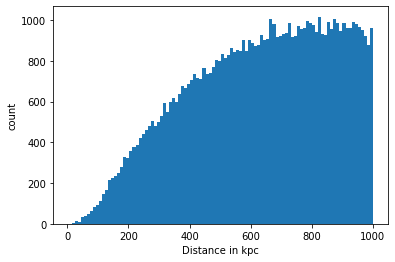

In [10]:
plt.hist(r[r['r_med_geo']<1000]['r_med_geo'],bins=100)
plt.xlabel('Distance in kpc')
plt.ylabel('count')

# Plot of Distance vs Ag

Text(0.5, 1.0, 'Extinction count')

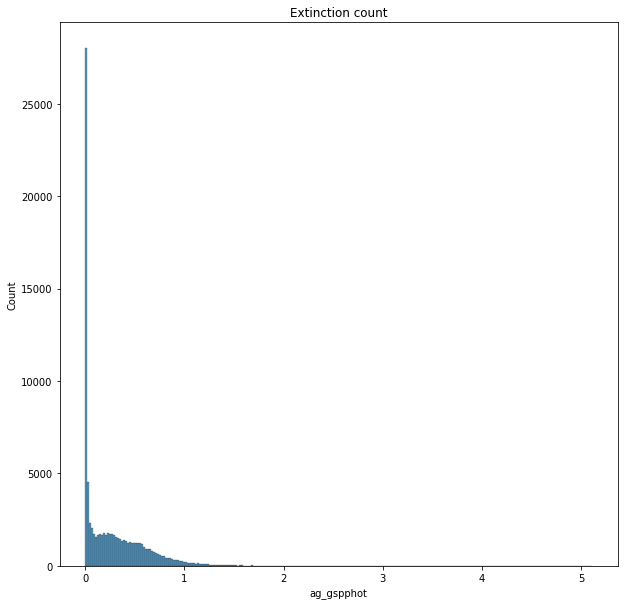

In [11]:
plt.figure(figsize=(10,10))
sn.histplot(r['ag_gspphot'])
#plt.xlim(0,2)
plt.title('Extinction count')

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extinction vs Distance')

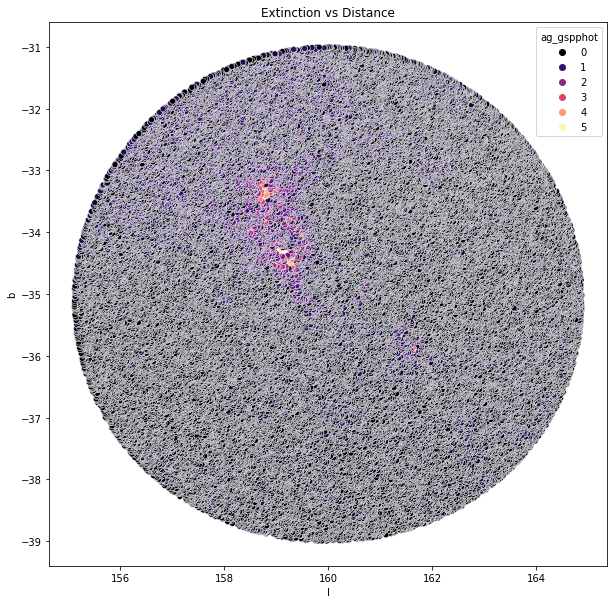

In [12]:
plt.figure(figsize=(10,10))
sn.scatterplot(r['l'],r['b'],hue=r['ag_gspphot'],color='r',s=35,palette='magma')
#plt.xlim(0,2)
plt.title('Extinction vs Distance')

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extinction vs Distance')

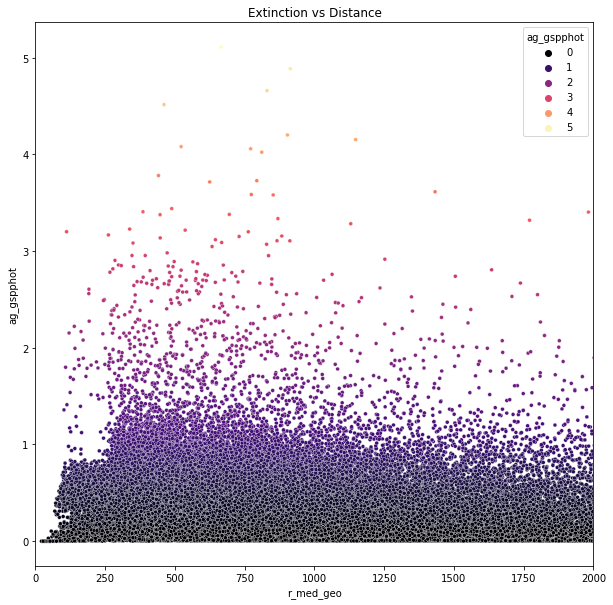

In [13]:
plt.figure(figsize=(10,10))
sn.scatterplot(r['r_med_geo'],r['ag_gspphot'],hue=r['ag_gspphot'],palette='magma',s=15)
plt.xlim(0,2000)
plt.title('Extinction vs Distance')

In [14]:
'''
scatter=r.copy()
scatter=scatter[scatter['r_med_geo']<1000].reset_index(drop=True)
import plotly.express as px

plt.figure(figsize=(10,10))
fig = px.scatter_3d(scatter, x='l', y='r_med_geo', z='b',
                    color='ag_gspphot')
fig.update_traces(marker=dict(size=4,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()'''

"\nscatter=r.copy()\nscatter=scatter[scatter['r_med_geo']<1000].reset_index(drop=True)\nimport plotly.express as px\n\nplt.figure(figsize=(10,10))\nfig = px.scatter_3d(scatter, x='l', y='r_med_geo', z='b',\n                    color='ag_gspphot')\nfig.update_traces(marker=dict(size=4,\n                              line=dict(width=2,\n                                        color='DarkSlateGrey')),\n                  selector=dict(mode='markers'))\nfig.show()"

In [15]:
high_lat=r
high_lat=high_lat.reset_index(drop=True)
high_lat=high_lat.dropna(axis=0,subset=['mh_gspphot']).reset_index(drop=True)

# Star_sample creation

In [16]:

import gdr3apcal



calib = gdr3apcal.GaiaDR3_GSPPhot_cal()
# Apply calibrations to [M/H] and/or Teff, returning a numpy array of calibrated values.
metal_calib = calib.calibrateMetallicity(high_lat)



high_lat=high_lat[['ra','dec','parallax','phot_g_mean_mag','phot_g_mean_flux','phot_rp_mean_flux','phot_bp_mean_flux',
                        'phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','ra_error','dec_error',
                        'parallax_error','phot_g_mean_flux_error','phot_bp_mean_flux_error',
                        'phot_rp_mean_flux_error','mh_gspphot','logg_gspphot','ag_gspphot','r_med_geo','j_m','h_m','ks_m','j_msigcom','h_msigcom','ks_msigcom']].reset_index(drop=True)

features=[['ra','dec','parallax','phot_g_mean_mag','bp_rp','j_m','h_m','k_m']]
errors=[['ra_error','dec_error','parallax_error','phot_g_mean_mag_error','bp_rp_error','j_msigcom','h_msigcom','ks_msigcom']]

Automatically adding "cos(b)" from "b" [assuming degrees].
Automatically adding "cos(b)" from "b" [assuming degrees].
Automatically adding "cos(b)" from "b" [assuming degrees].
Automatically adding "cos(b)" from "b" [assuming degrees].


In [17]:

high_lat=StarSample(high_lat,features,errors,twomass=True)


# Isochrones

In [18]:
filters = ["Gaia_G_EDR3", "Gaia_BP_EDR3", 'Gaia_RP_EDR3','2MASS_J','2MASS_KS','2MASS_H']
massgrid = 10*np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = np.linspace(9.0,10.0,10)
fehgrid = np.linspace(-2,0.5,110)
isocs=Isochrones(filters,logagegrid,massgrid,fehgrid,override=2.02,override2=0.499)

In [19]:
isocs.isochrones_list[0]

,logg,logteff,logl,mass,logage,feh,phase,Gaia_RP_EDR3,Gaia_G_EDR3,2MASS_J,...,BPRP,JK,p_slopes,slopes,p_slopes_2,slopes_2,low_c,high_c,low_c_2,high_c_2
0,5.263404,3.569434,-2.486764,0.130130,9.0,-2.0,0.0,10.460546,11.380116,9.265292,...,1.848538,0.891709,2.02,3.643666,0.499,6.598103,7.394181,7.646069,7.582835,7.928620
1,5.204918,3.587871,-2.284179,0.150150,9.0,-2.0,0.0,9.943003,10.814856,8.834521,...,1.693403,0.835014,2.02,5.794476,0.499,12.483461,7.221755,7.394181,7.382759,7.582835
2,5.177354,3.593212,-2.185223,0.170170,9.0,-2.0,0.0,9.692350,10.550152,8.609420,...,1.647721,0.818320,2.02,5.803943,0.499,12.509367,7.049028,7.221755,7.182403,7.382759
3,5.149676,3.598550,-2.086169,0.190190,9.0,-2.0,0.0,9.441456,10.285217,8.384058,...,1.602074,0.801638,2.02,7.052316,0.499,15.783249,6.892803,7.049028,7.007671,7.182403
4,5.125927,3.602229,-2.003401,0.210210,9.0,-2.0,0.0,9.232163,10.066283,8.192189,...,1.571029,0.790206,2.02,13.907291,0.499,27.626740,6.742401,6.892803,6.853104,7.007671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,4.486009,4.043253,1.259078,1.511512,9.0,-2.0,0.0,2.183078,2.126384,2.248878,...,-0.085547,-0.041478,2.02,25.724802,0.499,60.605252,2.238542,2.299189,2.250799,2.311053
70,4.469547,4.045569,1.290512,1.531532,9.0,-2.0,0.0,2.118880,2.060569,2.187121,...,-0.088105,-0.042480,2.02,43.448409,0.499,118.138328,2.171894,2.238542,2.184236,2.250799
71,4.449707,4.046969,1.321584,1.551552,9.0,-2.0,0.0,2.049978,1.990672,2.119710,...,-0.089714,-0.043046,2.02,97.353373,0.499,422.274215,2.098615,2.171894,2.110754,2.184236
72,4.426327,4.047552,1.352854,1.571572,9.0,-2.0,0.0,1.975593,1.915839,2.045967,...,-0.090483,-0.043220,2.02,115.305277,0.499,618.280474,2.022130,2.098615,2.034020,2.110754


# Pickle save

In [20]:
os.getcwd()

'/Users/mattocallaghan/VaeStar'

In [21]:
import pickle
os.chdir("Data")

output=open('isochrones_high_lat.pkl','wb') #convert to a dataframe
pickle.dump(isocs,output) #save to file



In [27]:
output=open('high_lat_values.pkl','wb') #convert to a dataframe
pickle.dump(high_lat,output)#save to file
#os.chdir('..')

In [23]:
high_lat.to_tensor()

tensor([[[4.5401e+01, 1.4829e+01, 1.8640e+00,  ..., 1.8353e-02,
          8.9086e-02, 1.1628e-01]],

        [[4.5427e+01, 1.4840e+01, 2.8506e-01,  ..., 6.4473e-03,
          1.4027e-02, 1.2554e-01]],

        [[4.5445e+01, 1.4855e+01, 1.1686e+00,  ..., 1.6838e-02,
          6.4601e-02, 1.5941e-01]],

        ...,

        [[4.2457e+01, 2.2291e+01, 4.6017e-01,  ..., 1.4891e-02,
          5.6396e-02,        nan]],

        [[4.2436e+01, 2.2281e+01, 1.1638e+00,  ..., 3.1267e-03,
          5.5881e-03, 3.6235e-02]],

        [[4.2446e+01, 2.2284e+01, 3.8420e+00,  ..., 2.8117e-03,
          4.7805e-03, 2.6249e-02]]], dtype=torch.float64)

In [24]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

,ra,dec,parallax,phot_g_mean_mag,phot_g_mean_flux,phot_rp_mean_flux,phot_bp_mean_flux,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,...,parallax_error,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,mh_gspphot,logg_gspphot,phot_g_mean_mag_error,bp_error,rp_error,bp_rp_error
0,44.281352,18.681245,0.743010,17.799953,1428.779116,1271.527708,557.732506,18.472477,16.987082,1.485395,...,0.124104,1.812249,11.057135,8.604890,-0.6505,4.7668,0.003080,0.021854,0.007860,0.023224
1,44.269818,18.654219,0.548729,16.749699,3758.959618,2980.249978,1655.067637,17.291502,16.062263,1.229239,...,0.070739,2.924474,18.865709,12.938982,-0.9396,4.7176,0.002882,0.012940,0.005478,0.014052
2,44.262053,18.652386,0.662536,15.548326,11366.228981,8563.711462,5453.401133,15.996874,14.916241,1.080633,...,0.042139,6.680903,14.635385,16.373699,-0.3245,4.3916,0.002828,0.004772,0.003478,0.005905
3,44.260644,18.650630,NaN,20.994844,75.337077,NaN,NaN,NaN,NaN,NaN,...,NaN,1.571888,NaN,NaN,NaN,NaN,0.022821,NaN,NaN,NaN
4,44.264347,18.649301,0.766578,14.243190,37815.584163,27384.137345,18740.359287,14.656597,13.654148,1.002449,...,0.020719,9.631531,29.684752,32.478729,-0.4244,4.0701,0.002769,0.004152,0.003073,0.005166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27187,46.249300,16.691827,1.399086,14.735081,24038.891456,17538.299286,12098.258385,15.131735,14.137927,0.993808,...,0.034192,9.724405,28.812962,36.886971,-0.8913,4.5522,0.002790,0.004579,0.003606,0.005828
27188,42.309880,16.675617,NaN,21.635550,41.756744,466.658190,158.660810,19.837368,18.075397,1.761971,...,NaN,1.320303,11.284405,22.821953,NaN,NaN,0.034440,0.077313,0.053171,0.093832
27189,46.257789,20.670736,1.105224,18.481249,762.864174,843.892023,175.138875,19.730085,17.432178,2.297907,...,0.220675,1.591388,11.129131,9.600273,0.0042,4.4945,0.003567,0.069096,0.012663,0.070247
27190,42.292541,16.676993,1.524901,18.447952,786.621255,943.885421,165.215341,19.793417,17.310596,2.482821,...,0.184836,1.698052,7.480907,20.985384,-0.8154,4.6220,0.003617,0.049307,0.024300,0.054970


# HR diagram

(array([7., 5., 5., 6., 1., 5., 2., 1., 5., 4.]),
 array([0.1659    , 0.1668    , 0.16770001, 0.16860001, 0.16950001,
        0.1704    , 0.1713    , 0.1722    , 0.1731    , 0.174     ,
        0.1749    ], dtype=float32),
 <BarContainer object of 10 artists>)

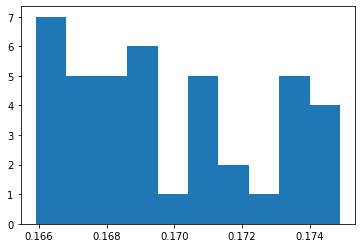

In [ ]:
high_lat.data=high_lat.data[high_lat.data['mh_gspphot']>0.165].reset_index(drop=True)
high_lat.data=high_lat.data[high_lat.data['mh_gspphot']<0.175].reset_index(drop=True)
plt.hist(high_lat.data['mh_gspphot'])

In [ ]:
high_lat.data.head(5)

,dist,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,error_over_parallax,pdist,phot_g_mean_mag_error,bp_error,rp_error,bp_rp_error,G
0,0.326618,1636148068921376768,Gaia DR3 84022930543557376,84022930543557376,154422376,2016.0,44.394184,0.049547,18.978551,0.041995,...,0.2664,0.2849,PHOENIX,0.028093,0.525560,0.002869,0.005596,0.003600,0.006654,7.441757
1,0.365930,1636148068921376768,Gaia DR3 35966678907628288,35966678907628288,762256713,2016.0,44.644299,0.028807,18.769796,0.023141,...,0.1723,0.2009,MARCS,0.018865,0.594314,0.002783,0.004678,0.003344,0.005750,6.048600
2,0.387801,1636148068921376768,Gaia DR3 83944212383021184,83944212383021184,863636240,2016.0,44.049249,0.025355,18.998950,0.020548,...,0.3797,0.3907,MARCS,0.008967,0.322262,0.002784,0.005249,0.003017,0.006055,7.406362
3,0.443895,1636148068921376768,Gaia DR3 35985439324772224,35985439324772224,92201530,2016.0,44.679718,0.046311,18.891783,0.039183,...,0.4626,0.4737,PHOENIX,0.021908,0.401964,0.002849,0.010331,0.003205,0.010817,8.193524
4,0.614748,1636148068921376768,Gaia DR3 84049971657597440,84049971657597440,257165352,2016.0,44.334234,0.124496,19.285119,0.122864,...,0.7463,0.7826,MARCS,0.088049,0.523684,0.004998,0.026946,0.005339,0.027470,8.678772


# CM Diagram

These metalicities in the Gaia catalogue have systematic uncertainties so have to be changed. The hue is these provided metalicities.

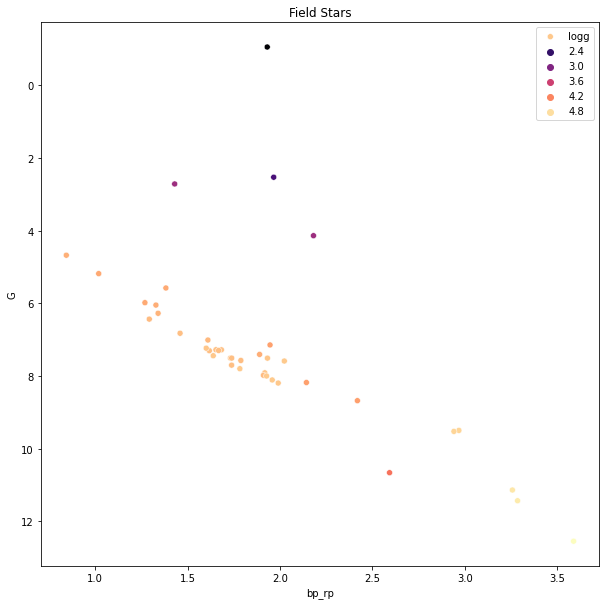

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)

scatter=high_lat.data
sn.scatterplot(x=scatter['bp_rp'],y=scatter['G'],hue=scatter['logg_gspphot'],ax=axes,label='logg',color='g',palette=sn.color_palette("magma", as_cmap=True))

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("Field Stars")
plt.show()

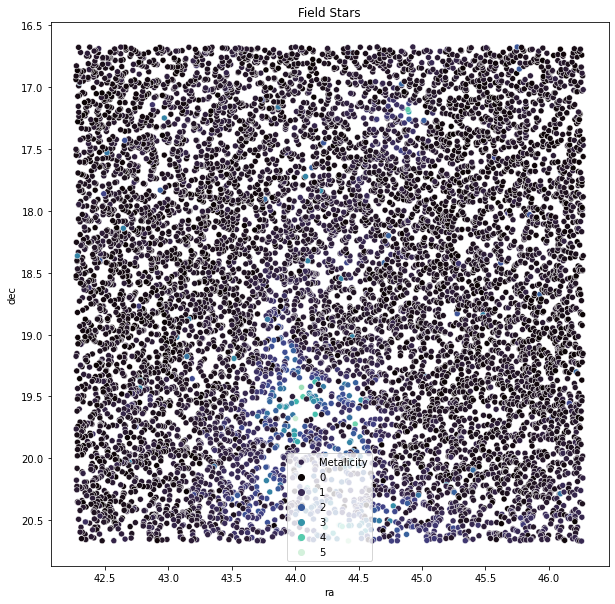

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=r[r['pdist']<1]
scatter=scatter[scatter['pdist']>0.0]
sn.scatterplot(x=scatter['ra'],y=scatter['dec'],hue=scatter['ag_gspphot'],ax=axes,label='Metalicity',color='g',palette=sn.color_palette("mako", as_cmap=True))

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("Field Stars")
plt.show()

# Here on in we assume we are pointing at the cloud region.

In general, we probably cant always use extinction to identify clouds. But for now, we are using the extinction to make sure we are roughly pointed at a cloud. We will begin by looking at the region in the distance range less than 1kpc.

KeyError: 'mean_absolute_mag_g_band'

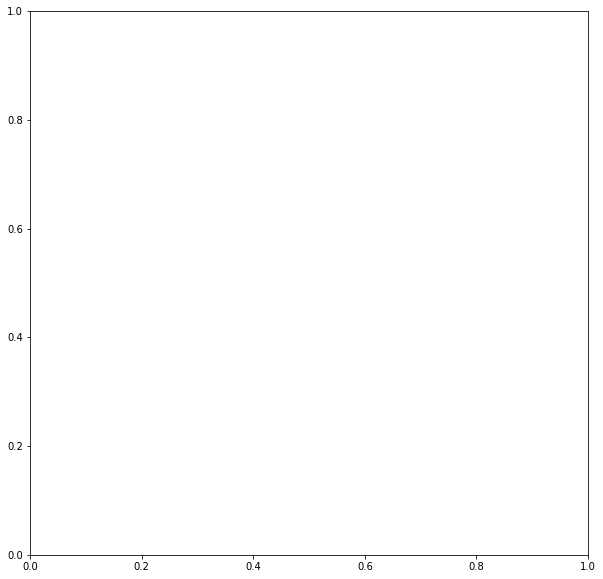

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=r[r['pdist']<1]
scatter2=scatter
#scatter=scatter[scatter['pdist']>0.1]
scatter=scatter[scatter['ra']>43]
scatter=scatter[scatter['ra']<45.5]
scatter=scatter[scatter['dec']>19.0]
scatter=scatter[scatter['rv_template_fe_h']>-0.1]
scatter=scatter[scatter['rv_template_fe_h']<0.1]

sn.scatterplot(x=scatter2['bp_rp'],y=scatter2['mean_absolute_mag_g_band'],ax=axes,s=10,color='g',label='no metalicity')
#sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rv_template_fe_h'],ax=axes,s=10,palette=sn.color_palette("magma", as_cmap=True))
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,color='r')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
#plt.legend()
axes.set_title("Field Stars")
plt.show()

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extinction vs Distance')

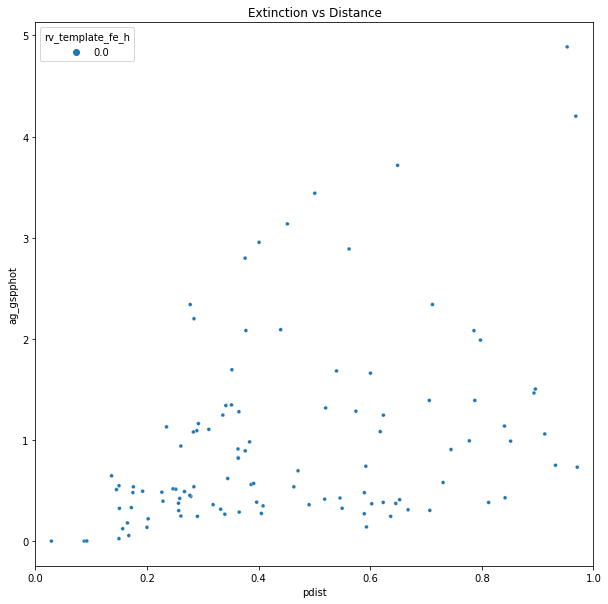

In [ ]:
plt.figure(figsize=(10,10))
sn.scatterplot(scatter['pdist'],scatter['ag_gspphot'],hue=scatter['rv_template_fe_h'],color='r',s=15)
plt.xlim(0,1)
plt.title('Extinction vs Distance')

In [ ]:
type(r)

astropy.table.table.Table

In [ ]:
r.sort('pdist')

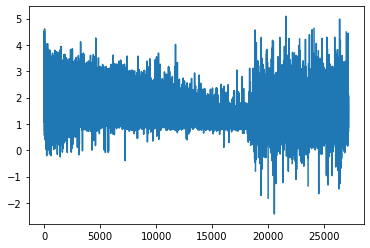

In [ ]:
plt.plot(r['bp_rp'])